<a href="https://colab.research.google.com/github/michaelg3709/FastAI-notebooks/blob/main/FastAI_Lesson2_Model_to_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/fastai/fastbook/blob/master/02_production.ipynb

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug  3 19:43:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install -Uqq fastbook
!pip install jmd_imagescraper

import fastbook  #import fast.ai library
from fastbook import *
fastbook.setup_book()
from fastai.vision.widgets import *

from pathlib import Path

#import the image scraper by @JoeDockrill, website: https://joedockrill.github.io/blog/2020/09/18/jmd-imagescraper-library/
from jmd_imagescraper.core import * 
from jmd_imagescraper.imagecleaner import *

In [4]:
bear_types = ['grizzly','black','teddy']
path = Path().cwd()/"bear_images" #assigns path to current working directory

In [ ]:
duckduckgo_search(path,"grizzly","grizzly_bear",max_results=100) #downloads 100 images of 'cats' and saves it in path/grizzly

In [ ]:
duckduckgo_search(path,"black","black_bear",max_results=100) #downloads 100 images of 'cats' and saves it in path/black

In [ ]:
duckduckgo_search(path,"teddy","teddy_bear",max_results=100) #downloads 100 images of 'cats' and saves it in path/teddy

In [8]:
display_image_cleaner(path)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

In [9]:
fns = get_image_files(path)
fns

(#300) [Path('/content/bear_images/teddy/008_8de8887c.jpg'),Path('/content/bear_images/teddy/033_0d4f2b8f.jpg'),Path('/content/bear_images/teddy/072_63b48fc6.jpg'),Path('/content/bear_images/teddy/098_a0959baa.jpg'),Path('/content/bear_images/teddy/010_f4ab2d16.jpg'),Path('/content/bear_images/teddy/040_dbfd9dc5.jpg'),Path('/content/bear_images/teddy/006_efe3a117.jpg'),Path('/content/bear_images/teddy/090_94d23d16.jpg'),Path('/content/bear_images/teddy/070_814abbbb.jpg'),Path('/content/bear_images/teddy/064_0f77ff1c.jpg')...]

In [10]:
failed=verify_images(fns) # look for files that arent images
failed
failed.map(Path.unlink); # unlink the failed files from the folder

In [13]:
# Create a Datablock object that sends the images to a DataLoaders class

bears=DataBlock(
    blocks=(ImageBlock, CategoryBlock),  #specify types for the independent and dependent variables
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),  # data transformation on image at a time
    batch_tfms=aug_transforms(mult=2)) # batch augmentation

In [15]:
# Create data loader
dls=bears.dataloaders(path)

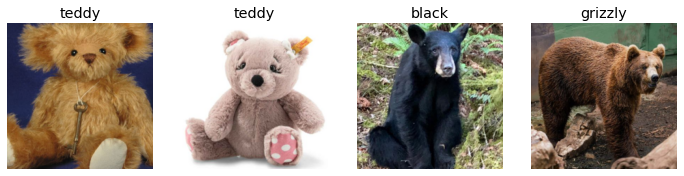

In [16]:
dls.valid.show_batch(max_n=4,nrows=1)

In [17]:
#Call a Learner that learns based on the input images in 4 epochs.
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.685435,0.213624,0.083333,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.515037,0.149358,0.050000,00:02
1,0.414326,0.108734,0.050000,00:02
2,0.371741,0.101395,0.050000,00:02
3,0.322284,0.094534,0.050000,00:02


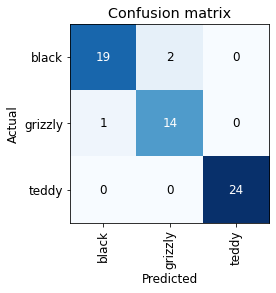

In [18]:
# Confusion matrix 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

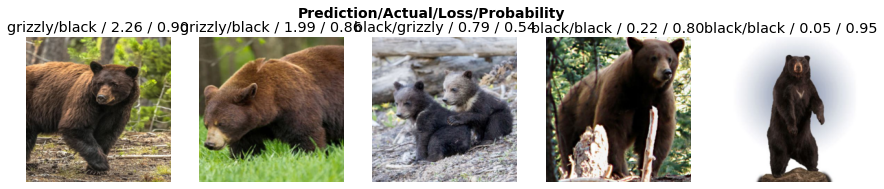

In [19]:
# Show images with highest loss in dataset
interp.plot_top_losses(5, nrows = 1)

In [20]:
# Data clean
cleaner = ImageClassifierCleaner(learn)
cleaner

In [21]:
# Move, delete cleaned images

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
# Export the model

learn.export()

### Use model for interference

In [24]:
path = Path()
learn_inf = load_learner(path/'bear_classifier.pkl', cpu=True)

btn_upload = widgets.FileUpload() # Upload button
    
out_pl = widgets.Output() # output placeholder
lbl_pred = widgets.Label() # prediction label

In [26]:
# Click event handler
def on_click_classify(change):
  lbl_pred.value = ''
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

# Upload button
btn_upload.observe(on_click_classify, names=['data'])

# Display widget
display(VBox([widgets.Label('Select your bear!'), btn_upload, out_pl, lbl_pred]))